<a href="https://colab.research.google.com/github/AhmadIsmail83N/MyData/blob/master/Dz1_Dz2_Ahmad_7_6_2020_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup**

In [0]:
%tensorflow_version 1.x
%matplotlib inline
import tensorflow as tf
import numpy as np
import base64
import csv
import os
from PIL import Image
import skimage.io as M
from sklearn.model_selection import train_test_split
import pathlib
import time
from scipy import io 
import matplotlib.pyplot as plt

from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
#import scipy.io
from tensorflow import keras
from google.colab import files
from keras.utils import np_utils #to_categorical


TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
#!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
cv2.__version__

'4.1.2'



**1-  Get Data Set**

In [0]:
tfrecords_Train ='/content/drive/My Drive/TFrecords/train.tfrecords'
# '/content/drive/My Drive/TFrecords/train.tfrecords'

tfrecords_Test ='/content/drive/My Drive/TFrecords/test.tfrecords'
# '/content/drive/My Drive/TFrecords/test.tfrecords'
IMAGE_SHAPE = (224, 224)

**Prepare data set**

In [0]:
train_images_root = tf.keras.utils.get_file('cars_train',
                                    'http://imagenet.stanford.edu/internal/car196/cars_train.tgz',
                                     untar=True
                                    )
train_dir = pathlib.Path(train_images_root)



In [0]:
test_images_root = tf.keras.utils.get_file('cars_test',
                                    'http://imagenet.stanford.edu/internal/car196/cars_test.tgz',
                                     untar=True
                                    )
test_dir = pathlib.Path(test_images_root)


In [0]:
train_images_paths= list(train_dir.glob('*.jpg'))
train_image_count=len(train_images_paths)
print(train_image_count,' Train Images Found')

test_images_paths= list(test_dir.glob('*.jpg'))
test_image_count=len(test_images_paths)
print(test_image_count,' Test Images Found')


In [0]:
#classes names
names = io.loadmat('/content/drive/My Drive/TFrecords/cars_meta.mat')
label_name=names['class_names'][0]


train_codes = io.loadmat('/content/drive/My Drive/TFrecords/cars_train_annos.mat')
train_label_codes=(train_codes['annotations']['class'][0])


test_codes = io.loadmat('/content/drive/My Drive/TFrecords/cars_test_annos.mat')
test_label_codes=(train_codes['annotations']['class'][0])


class_count=len(label_name)
print(class_count, " Classes found!")
#for j in range(0,class_count):
#  print (j,"|",label_name[j][0])

196  Classes found!


In [0]:
def getTrainPath(index):
  s='/root/.keras/datasets/cars_train/'
  s+='{0:05}'.format(index)
  s+='.jpg'
  return s


def getTrainLabel(index):
  return label_name[train_label_codes[index-1]-1][0][0][0]


def getTestPath(index):
  s='/root/.keras/datasets/cars_test/'
  s+='{0:05}'.format(index)
  s+='.jpg'
  return s


def getTestLabel(index):
  return label_name[test_label_codes[index-1]-1][0][0][0]

**2- Create TFrecord file**

In [0]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [0]:
def write_data_tfrecord(index,fname,label,tf_writer):
  
  img    =  cv2.imread(fname,cv2.IMREAD_UNCHANGED)
  if len(img.shape)!=3:
    return
  dim    = (224, 224)
  # resize image
  resized = cv2.resize(img, dim)
  #print(resized.shape)
  img    =  np.array(resized)
  height =  img.shape[0]
  width  =  img.shape[1]
  
  img_raw = img.tostring()
  example = tf.train.Example(features=tf.train.Features(feature={
        'height'      : _int64_feature(height),
        'width'       : _int64_feature(width),
        'image_raw'   : _bytes_feature(img_raw),
        'image_label' : _int64_feature(label)
         })) 
  tf_writer.write(example.SerializeToString())
  

Create train Tfrecord file

In [0]:
writer = tf.python_io.TFRecordWriter(tfrecords_Train)
for i in range(0,train_image_count):
  f=getTrainPath(i+1)
  l=train_label_codes[i]
  write_data_tfrecord(i,f,l,writer)
writer.close()

Create Test Tfrecord file

In [0]:
writer = tf.python_io.TFRecordWriter(tfrecords_Test)
for i in range(0,test_image_count):
  f=getTestPath(i+1)
  l=test_label_codes[i]
  write_data_tfrecord(i,f,l,writer)
writer.close()

**3- Read TfRecord**

create function to read images and labels by queue from file

In [0]:
def read_images_labels(example_proto):
  
    features = tf.parse_single_example(
      example_proto,
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature( [],tf.string),
        'image_label': tf.FixedLenFeature([],tf.int64)        
        })
    
    image = tf.decode_raw(features['image_raw'], tf.uint8) 
    #height = tf.cast(features['height'], tf.int32)
    #width = tf.cast(features['width'], tf.int32)
    label = tf.cast(features['image_label'], tf.int32)
    image_shape = tf.stack([224, 224, 3])
    image = tf.reshape(image, image_shape)
  
    resized_image    = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=224,
                                           target_width=224)
    
    
    return image,label

**Session to read all data from tfrecord files**

In [0]:
batch_size=1
dataset=tf.data.TFRecordDataset(tfrecords_Train)
dataset = dataset.map(read_images_labels).cache()
dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(100000,))
dataset = dataset.batch(batch_size).prefetch(1)

iterator = dataset.make_one_shot_iterator()
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer()
                  )
image_batch, Label_batch = iterator.get_next()
with tf.compat.v1.Session()  as sess:
    sess.run(init_op)    
    start_time = time.time()
    for i in range(0,8000):      
      img,lbl=sess.run([image_batch, Label_batch])
      currTime= time.time()- start_time
      print("Batch index:",i,'Time {:0.2f}'.format(currTime),"Car Model:",label_name[lbl[0]-1][0])

Streaming output truncated to the last 5000 lines.
Batch index: 3001 Time 7.27 Car Model: Ford F-150 Regular Cab 2007
Batch index: 3002 Time 7.27 Car Model: Dodge Caravan Minivan 1997
Batch index: 3003 Time 7.27 Car Model: Volkswagen Beetle Hatchback 2012
Batch index: 3004 Time 7.27 Car Model: Acura TL Sedan 2012
Batch index: 3005 Time 7.27 Car Model: Audi TTS Coupe 2012
Batch index: 3006 Time 7.27 Car Model: Dodge Caliber Wagon 2007
Batch index: 3007 Time 7.28 Car Model: Ford Freestar Minivan 2007
Batch index: 3008 Time 7.28 Car Model: Daewoo Nubira Wagon 2002
Batch index: 3009 Time 7.28 Car Model: Audi R8 Coupe 2012
Batch index: 3010 Time 7.28 Car Model: GMC Yukon Hybrid SUV 2012
Batch index: 3011 Time 7.28 Car Model: Rolls-Royce Phantom Drophead Coupe Convertible 2012
Batch index: 3012 Time 7.28 Car Model: Infiniti G Coupe IPL 2012
Batch index: 3013 Time 7.28 Car Model: Acura Integra Type R 2001
Batch index: 3014 Time 7.28 Car Model: Hyundai Veracruz SUV 2012
Batch index: 3015 Time 

**show some images from tfrecord file**

Batch index: 0 Time 3.60 Car Model: Audi S4 Sedan 2012


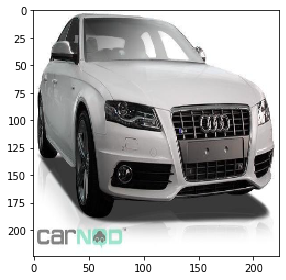

Batch index: 1 Time 3.85 Car Model: Chevrolet TrailBlazer SS 2009


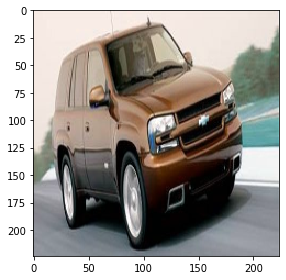

Batch index: 2 Time 4.08 Car Model: Nissan 240SX Coupe 1998


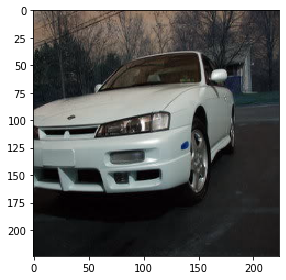

Batch index: 3 Time 4.32 Car Model: GMC Acadia SUV 2012


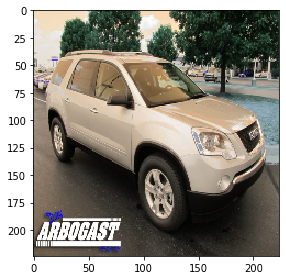

Batch index: 4 Time 4.55 Car Model: Volkswagen Beetle Hatchback 2012


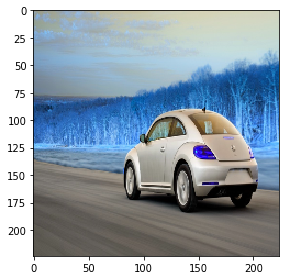

In [0]:
import skimage.io as io
batch_size=1
dataset=tf.data.TFRecordDataset(tfrecords_Train)
dataset = dataset.map(read_images_labels).cache()
dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(100000,))
dataset = dataset.batch(batch_size).prefetch(1)

iterator = dataset.make_one_shot_iterator()
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer()
                  )
image_batch, Label_batch = iterator.get_next()
with tf.compat.v1.Session()  as sess:
    sess.run(init_op)
    
    start_time = time.time()
    for i in range(0,5):      
      img,lbl=sess.run([image_batch, Label_batch])
      currTime= time.time()- start_time
      print("Batch index:",i,'Time {:0.2f}'.format(currTime),"Car Model:",label_name[lbl[0]-1][0])
      io.imshow(img[0])
      io.show()

-----------------------------------------------

**Transfer Learning**


pretrained Model

In [0]:
base_model =VGG19(weights='imagenet')
base_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________

In [0]:
y = base_model.output
#y = Flatten()(y)
y = Dense(100, activation='relu')(y)
predictions = Dense(196, activation='softmax')(y)  

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = True#False


model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()              


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
#import skimage.io as io
batch_size=1
train_dataset  =  tf.data.TFRecordDataset(tfrecords_Train)
train_dataset  =  train_dataset.map(read_images_labels).cache()

train_dataset = train_dataset.apply(tf.data.experimental.shuffle_and_repeat(100000,))
train_dataset = train_dataset.batch(batch_size).prefetch(1)

#new
val_dataset=tf.data.TFRecordDataset(tfrecords_Test)
val_dataset = val_dataset.map(read_images_labels).cache()

val_dataset = val_dataset.apply(tf.data.experimental.shuffle_and_repeat(100000,))
val_dataset = val_dataset.batch(batch_size).prefetch(1)




train_iterator = train_dataset.make_one_shot_iterator()
val_iterator   = val_dataset  .make_one_shot_iterator()

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer()
                  )

x_trian, y_train = train_iterator.get_next()
x_test, y_test   = val_iterator  .get_next()


with tf.compat.v1.Session()  as sess:

    sess.run(init_op)    
    start_time = time.time()
    
    for i in range(0,5):   

      img      , lbl          =sess.run([x_trian, y_train])
      img_test , lbl_test     =sess.run([x_test , y_test])      

      lbl_cat      = np_utils.to_categorical(lbl     , 196)
      lbl_test_cat = np_utils.to_categorical(lbl_test, 196)
      

      history=model.fit(img,lbl_cat,
                epochs=1,
                batch_size=1,
                validation_data=(img_test, lbl_test_cat)
                )
      currTime= time.time()- start_time
      print("Batch index:",i,'Time {:0.2f}'.format(currTime),"Car Model:",label_name[lbl[0]-1][0])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1 samples, validate on 1 samples
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 0.0320 - accuracy: 0.9949 - val_loss: 0.0320 - val_accuracy: 0.9949
Batch index: 0 Time 37.79 Car Model: Dodge Durango SUV 2007
Train on 1 samples, validate on 1 samples
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 0.0320 - accuracy: 0.9949 - val_loss: 0.0320 - val_accuracy: 0.9949
Batch index: 1 Time 41.89 Car Model: Volkswagen Golf Hatchback 1991
Train on 1 samples, validate on 1 samples
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 0.0320 - accuracy: 0.9949 - val_loss: 0.0320 - val_accuracy: 0.9949
Batch index: 2 Time 45.62 Car Model: BMW M3 Coupe 2012
Train on 1 samples, validate on 1 samples
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 0.0320 - accuracy: 0.9949 - val_loss: 0.0320 - val_accuracy: 0.9949
Batch index